In [1]:
from imutils.perspective import four_point_transform
from imutils import contours
from matplotlib import pyplot as plt
import imutils
import cv2

In [2]:
DIGITS_LOOKUP = {
	(1, 1, 1, 0, 1, 1, 1): 0,
	(0, 0, 1, 0, 0, 1, 0): 1,
	(1, 0, 1, 1, 1, 1, 0): 2,
	(1, 0, 1, 1, 0, 1, 1): 3,
	(0, 1, 1, 1, 0, 1, 0): 4,
	(1, 1, 0, 1, 0, 1, 1): 5,
	(1, 1, 0, 1, 1, 1, 1): 6,
	(1, 0, 1, 0, 0, 1, 0): 7,
	(1, 1, 1, 1, 1, 1, 1): 8,
	(1, 1, 1, 1, 0, 1, 1): 9
}

In [3]:
image = cv2.imread("image16.jpg")

cap = cv2.VideoCapture(0)

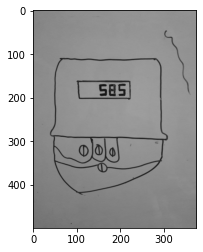

In [4]:
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 50, 200, 255)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))


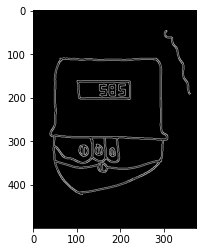

In [5]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
displayCnt = None
plt.imshow(cv2.cvtColor(edged,cv2.COLOR_BGR2RGB))

In [6]:
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
	# if the contour has four vertices, then we have found
	# the bill display
	if len(approx) == 4:
		displayCnt = approx
		break

In [7]:
warped = four_point_transform(gray, displayCnt.reshape(4, 2))
output = four_point_transform(image, displayCnt.reshape(4, 2))

In [8]:
thresh = cv2.threshold(warped, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

In [9]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digitCnts = []


In [10]:
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
 
	# if the contour is sufficiently large, it must be a digit
	if w >= 15 and (h >= 30 and h <= 40):
		digitCnts.append(c)

# sort the contours from left-to-right, then initialize the
# actual digits themselves
digitCnts = contours.sort_contours(digitCnts,
	method="left-to-right")[0]
digits = []

In [11]:
for c in digitCnts:
	# extract the digit ROI
	(x, y, w, h) = cv2.boundingRect(c)
	roi = thresh[y:y + h, x:x + w]
 
	# compute the width and height of each of the 7 segments
	# we are going to examine
	(roiH, roiW) = roi.shape
	(dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
	dHC = int(roiH * 0.05)
 
	# defining 7segment display
	segments = [
		((0, 0), (w, dH)),	# top
		((0, 0), (dW, h // 2)),	# top-left
		((w - dW, 0), (w, h // 2)),	# top-right
		((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
		((0, h // 2), (dW, h)),	# bottom-left
		((w - dW, h // 2), (w, h)),	# bottom-right
		((0, h - dH), (w, h))	# bottom
	]
	on = [0] * len(segments)
        # loop over the segments
	for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
		# extract the segment ROI, count the total number of
		# thresholded pixels in the segment, and then compute
		# the area of the segment
		segROI = roi[yA:yB, xA:xB]
		total = cv2.countNonZero(segROI)
		area = (xB - xA) * (yB - yA)
 
		# if the total number of non-zero pixels is greater than
		# 40% of the area, mark the segment as "on"
		if total / float(area) > 0.4:
			on[i]= 1
 
	# lookup the digit and draw it on the image
	digit = DIGITS_LOOKUP[tuple(on)]
	digits.append(digit)
	cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
	cv2.putText(output, str(digit), (x - 10, y - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
# display the digits

In [12]:
print(digits)

[5, 8, 5]


In [13]:
#Mailing

import smtplib, ssl

def send_email(base, record):
    sender_email = "electricitybillnotifier@gmail.com"
    receiver_email = "demesaikiran1729@gmail.com"
    password = "Electricity@jntuh"
    message = "You have used "+ str(record - base) + " units till now, Decrese your power consumption"
    
    context = ssl.create_default_context()
    with smtplib.SMTP_SSL("smtp.gmail.com", 465, context = context) as server:
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, message)
    """"server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
    server.starttls()
    server.login(sender_email, password)"""
        
    

In [14]:
result = 0
for i in digits:
    result = result * 10 + i
base = 500
result


585

In [15]:
if result - base >= 80:
    send_email(base, result)